It is commented out, but the first cell *(re)installs* your python modules and forces them to be a specific version that works with this notebook, since several methods used by `fcapy` lib are either removed or deprecated in newer versions of its dependencies.

In [1]:
# !pip install --force-reinstall numpy==1.26.4
# !pip install --force-reinstall torch==2.1.0 torchvision==0.16.0 torchaudio==2.1.0 --index-url https://download.pytorch.org/whl/cpu
# !pip install --force-reinstall fcapy
# !pip install --force-reinstall frozendict=2.3.8
# !pip install --force-reinstall ipynb
# !pip install --force-reinstall sparselinear
# !pip install --force-reinstall bitsets=0.8.3
# !pip install --force-reinstall bitarray=2.9.3
# !pip install --force-reinstall torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.1.0+cpu.html
# !pip install --force-reinstall torch-cluster -f https://data.pyg.org/whl/torch-2.1.0+cpu.html
# !pip install --force-reinstall git+https://github.com/pyg-team/pytorch_geometric.git

In [2]:
%load_ext jupyter_black

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, f1_score

In [4]:
RANDOM_SEED = 42

In this assignment we will use the [kaggle version](https://www.kaggle.com/datasets/prishasawhney/mushroom-dataset) of [Secondary Mushroom](https://archive.ics.uci.edu/dataset/848/secondary+mushroom+dataset) dataset. The goal is to categorize a hypothetical mushroom as poisonous or edible by its physical attributes.

In [5]:
import platform

if platform.system() == "Windows":
    address = "data\\"
else:
    address = "data/"

df = (
    pd.read_csv(address + "mushroom_cleaned.csv")
    # .groupby(by=["class"])
    # .sample(frac=0.05, random_state=RANDOM_SEED)
)
df.head()

,cap-diameter,cap-shape,gill-attachment,gill-color,stem-height,stem-width,stem-color,season,class
0,1372,2,2,10,3.807467,1545,11,1.804273,1
1,1461,2,2,10,3.807467,1557,11,1.804273,1
2,1371,2,2,10,3.612496,1566,11,1.804273,1
3,1261,6,2,10,3.787572,1566,11,1.804273,1
4,1305,6,2,10,3.711971,1464,11,0.943195,1


# 1. Other models

Having selected the dataset, let's evaluate the performance of several widely used models such as `GaussianNB`, `RandomForestClassifier` and `HistGradientBoostingClassifier` to have a baseline to which we will compare `NeuralFCA`.

In [6]:
num_cols = ["cap-diameter", "stem-height", "stem-width"]
# cat_cols = ["cap-shape", "gill-attachment", "gill-color", "stem-color", "season"]
cat_cols = ["season"]

In [7]:
df = df.drop(["cap-shape", "gill-attachment", "gill-color", "stem-color"], axis=1)

`season` feature looks really suspicious, so let's check its distribution. It has only 4 unique values(referencing the original dataset and common sense, we can tell that those are winter, spring, summer and autumn in *some* order), therefore we will treat it as a categorical feature.

In [8]:
df.season.value_counts()

season
0.943195    27210
0.888450    20387
1.804273     4219
0.027372     2219
Name: count, dtype: int64

In [9]:
seasons = dict(
    zip(df.season.value_counts().index, ["s" + str(i + 1) for i in range(4)])
)
df = df.replace({"season": seasons})

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(["class"], axis=1),
    df["class"],
    random_state=RANDOM_SEED,
    stratify=df["class"],
)

In [11]:
column_transformer = ColumnTransformer(
    transformers=[
        (
            "ohe",
            OneHotEncoder(handle_unknown="ignore", sparse_output=False),
            cat_cols,
        ),
        ("scaling", StandardScaler(), num_cols),
    ],
    remainder="passthrough",
)

In [12]:
pipe_gnb = Pipeline(
    steps=[
        ("preprocessor", column_transformer),
        (
            "classifier",
            GaussianNB(),
        ),
    ]
)

pipe_rfc = Pipeline(
    steps=[
        ("preprocessor", column_transformer),
        (
            "classifier",
            RandomForestClassifier(
                random_state=RANDOM_SEED,
                n_estimators=100,
            ),
        ),
    ]
)

pipe_hgb = Pipeline(
    steps=[
        ("preprocessor", column_transformer),
        (
            "classifier",
            HistGradientBoostingClassifier(
                random_state=RANDOM_SEED,
                class_weight="balanced",
            ),
        ),
    ]
)

pipes = [pipe_gnb, pipe_rfc, pipe_hgb]

In [13]:
scores = dict()
for pipe in pipes:
    y_pred = pipe.fit(X_train, y_train).predict(X_test)
    scores[str(pipe["classifier"])] = [
        f1_score(y_test, y_pred),
        accuracy_score(y_test, y_pred),
    ]
    print(f"{str(pipe['classifier'])}:\n{classification_report(y_test, y_pred)}")

GaussianNB():
              precision    recall  f1-score   support

           0       0.61      0.27      0.37      6090
           1       0.59      0.86      0.70      7419

    accuracy                           0.59     13509
   macro avg       0.60      0.56      0.54     13509
weighted avg       0.60      0.59      0.55     13509

RandomForestClassifier(random_state=42):
              precision    recall  f1-score   support

           0       0.77      0.78      0.78      6090
           1       0.82      0.81      0.82      7419

    accuracy                           0.80     13509
   macro avg       0.80      0.80      0.80     13509
weighted avg       0.80      0.80      0.80     13509

HistGradientBoostingClassifier(class_weight='balanced', random_state=42):
              precision    recall  f1-score   support

           0       0.73      0.84      0.78      6090
           1       0.85      0.75      0.80      7419

    accuracy                           0.79     13509

# 2. `NeuralFCA` model

Let's construct a neural network classifier with its architecture based on a concept lattice.

In [14]:
import torch
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from fcapy.context import FormalContext
from fcapy.lattice import ConceptLattice
from fcapy.visualizer import LineVizNx
import matplotlib.pyplot as plt

In [15]:
plt.rcParams["figure.facecolor"] = (1, 1, 1, 1)

In [16]:
import neural_lib as nl

## Binarizing the data

First step of constructing a concept lattice is binarizing the features. For categorical features this can be done using OneHot encoding and for numerical data ordinal or interordinal scale is used. We will use the latter, seeing that it preserves more information about the feature.

In [17]:
def fca_ordinal_scale(dataframe, features, n_nodes=3, mode="ordinal"):
    if not isinstance(mode, str):
        raise TypeError(
            f"Invalid mode provided. Function accepts str, got {mode.__class__.__name__}"
        )

    if not isinstance(n_nodes, list) and isinstance(n_nodes, int):
        n_nodes = [n_nodes] * len(features)
    elif isinstance(n_nodes, list):
        if len(n_nodes) != len(features):
            raise ValueError(
                f"Incorrect number of nodes provided. Got {len(n_nodes)} instead of {len(features)}"
            )
    else:
        raise TypeError(
            f"n_nodes must be either int or list. Got {n_nodes.__class__.__name__} instead."
        )

    for feature, nodes in zip(features, n_nodes):
        x0 = dataframe[feature].min()
        dx = (dataframe[feature].max() - dataframe[feature].min()) / (nodes - 1)
        for i in range(nodes):
            if mode == "ordinal":
                dataframe[f"{feature} >={x0 + i * dx:0.4f}"] = dataframe[feature] >= (
                    x0 + i * dx
                )
            elif mode == "ordinal_inv":
                dataframe[f"{feature} <={x0 + i * dx:0.4f}"] = dataframe[feature] <= (
                    x0 + i * dx
                )
            elif mode == "interordinal":
                dataframe[f"{feature} >={x0 + i * dx:0.4f}"] = dataframe[feature] >= (
                    x0 + i * dx
                )
                dataframe[f"{feature} <={x0 + i * dx:0.4f}"] = dataframe[feature] <= (
                    x0 + i * dx
                )
            else:
                raise ValueError(
                    f"Invalid scaling mode provided. Available modes are: ordinal, ordinal_inv, interordinal. Got {mode.__class__.__name__}:{mode}"
                )
    return dataframe.drop(features, axis=1)

In [18]:
df_scaled = fca_ordinal_scale(df, num_cols, n_nodes=3, mode="interordinal")
df_scaled.columns

Index(['season', 'class', 'cap-diameter >=0.0000', 'cap-diameter <=0.0000',
       'cap-diameter >=945.5000', 'cap-diameter <=945.5000',
       'cap-diameter >=1891.0000', 'cap-diameter <=1891.0000',
       'stem-height >=0.0004', 'stem-height <=0.0004', 'stem-height >=1.9179',
       'stem-height <=1.9179', 'stem-height >=3.8353', 'stem-height <=3.8353',
       'stem-width >=0.0000', 'stem-width <=0.0000', 'stem-width >=1784.5000',
       'stem-width <=1784.5000', 'stem-width >=3569.0000',
       'stem-width <=3569.0000'],
      dtype='object')

## Building the concept lattice

Now that we prepared our data, we can construct the monotone Concept Lattice in order for it to be the basis of NN's architecture.

In [19]:
X_trainNN, X_testNN, y_trainNN, y_testNN = train_test_split(
    df_scaled.drop(["class"], axis=1),
    df_scaled["class"],
    random_state=RANDOM_SEED,
    stratify=df_scaled["class"],
)

In [20]:
enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
enc.fit(X_trainNN[cat_cols])

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [21]:
X_trainNN[enc.get_feature_names_out()] = enc.transform(X_trainNN[cat_cols]).astype(bool)
X_testNN[enc.get_feature_names_out()] = enc.transform(X_testNN[cat_cols]).astype(bool)
y_trainNN = y_trainNN.astype(bool)
y_testNN = y_testNN.astype(bool)

try:
    X_trainNN = X_trainNN.drop(cat_cols, axis=1)
    X_testNN = X_testNN.drop(cat_cols, axis=1)
except:
    pass

In [22]:
X_trainNN.head()

,cap-diameter >=0.0000,cap-diameter <=0.0000,cap-diameter >=945.5000,cap-diameter <=945.5000,cap-diameter >=1891.0000,cap-diameter <=1891.0000,stem-height >=0.0004,stem-height <=0.0004,stem-height >=1.9179,stem-height <=1.9179,...,stem-width >=0.0000,stem-width <=0.0000,stem-width >=1784.5000,stem-width <=1784.5000,stem-width >=3569.0000,stem-width <=3569.0000,season_s1,season_s2,season_s3,season_s4
5865,True,False,False,True,False,True,True,False,False,True,...,True,False,False,True,False,True,True,False,False,False
8365,True,False,False,True,False,True,True,False,False,True,...,True,False,False,True,False,True,False,True,False,False
37786,True,False,False,True,False,True,True,False,False,True,...,True,False,False,True,False,True,False,True,False,False
36741,True,False,False,True,False,True,True,False,False,True,...,True,False,False,True,False,True,False,False,False,True
6948,True,False,False,True,False,True,True,False,False,True,...,True,False,False,True,False,True,True,False,False,False


Due to the quirks of our dataset and python libs alike, we have to make sure that out indexes are strings:

In [23]:
X_trainNN.index = [str(idx) for idx in X_trainNN.index]
X_testNN.index = [str(idx) for idx in X_testNN.index]
y_trainNN.index = [str(idx) for idx in y_trainNN.index]
y_testNN.index = [str(idx) for idx in y_testNN.index]

In [24]:
K_train = FormalContext.from_pandas(X_trainNN)
K_train

FormalContext (40526 objects, 22 attributes, 406154 connections)
     |cap-diameter >=0.0000|cap-diameter <=0.0000|cap-diameter >=945.5000|cap-diameter <=945.5000|cap-diameter >=1891.0000|...|stem-width <=3569.0000|season_s1|season_s2|season_s3|season_s4|
5865 |                    X|                     |                       |                      X|                        |...|                     X|        X|         |         |         |
8365 |                    X|                     |                       |                      X|                        |...|                     X|         |        X|         |         |
37786|                    X|                     |                       |                      X|                        |...|                     X|         |        X|         |         |
36741|                    X|                     |                       |                      X|                        |...|                     X|         |         | 

In [25]:
L = ConceptLattice.from_context(K_train, algo="Sofia", is_monotone=True)
len(L)

102

## Making predictions

With the concept lattice done, we can make predictions using extents of our concepts and rank them by their $F_1$ score. Then by selecting a couple of best-performing concepts we can finally construct our NN measure its performance.

In [26]:
for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
    c.measures["f1_score"] = f1_score(y_trainNN, y_preds)

In [27]:
concepts_count = 20
best_concepts = list(L.measures["f1_score"].argsort()[::-1][:concepts_count])

assert (
    len({g_i for c in L[best_concepts] for g_i in c.extent_i}) == K_train.n_objects
), "Selected concepts do not cover all train objects"

In [28]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_trainNN)))

In [29]:
vis = LineVizNx(
    node_label_font_size=10,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn.attributes))
    + "\n\n",
    edge_cmap="hsv",
)

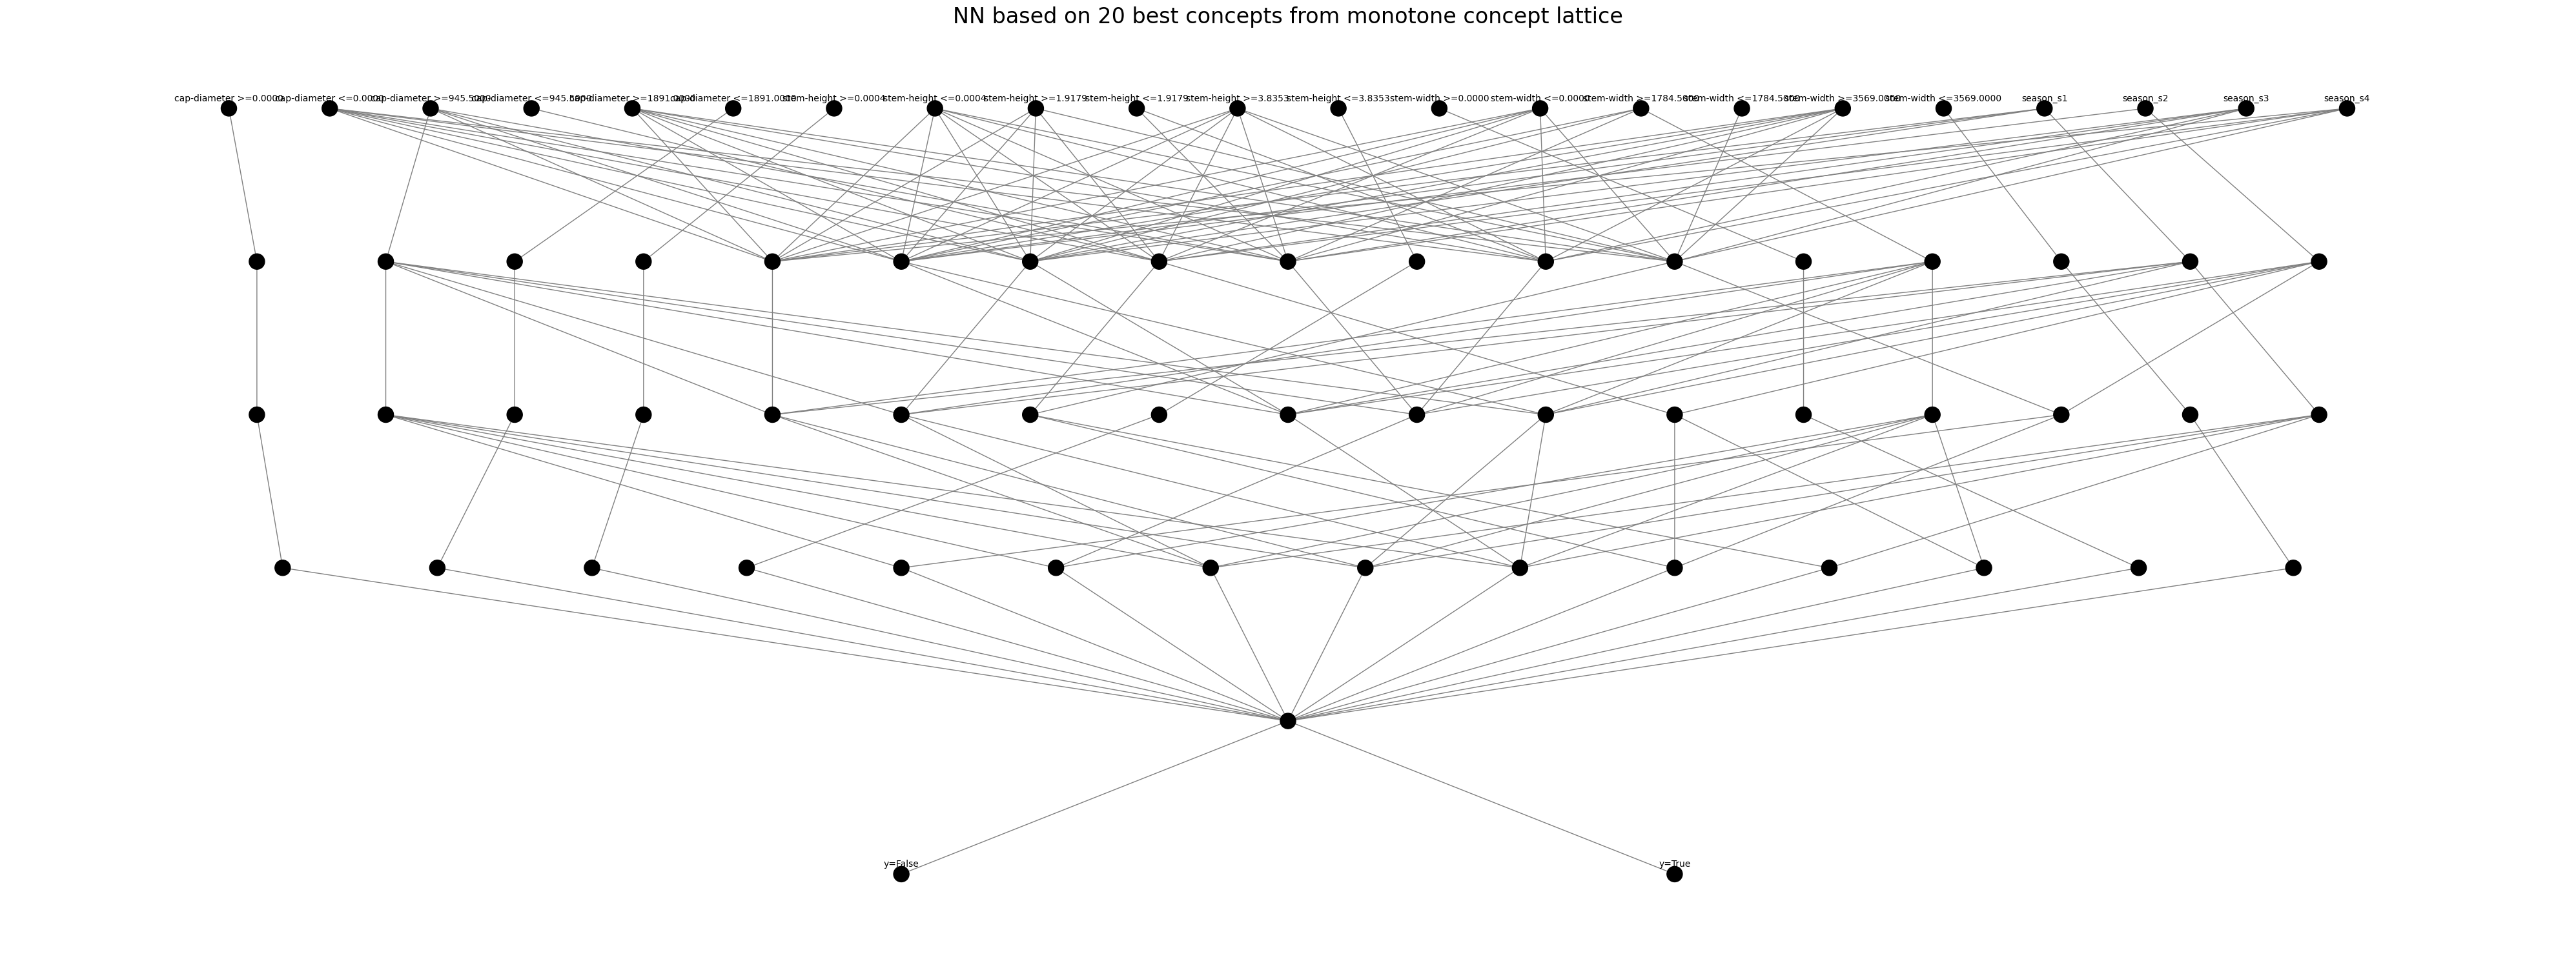

In [30]:
fig, ax = plt.subplots(figsize=(40, 15))

vis.draw_poset(
    cn.poset,
    ax=ax,
    edge_color="grey",
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(
        el_i, P, set(cn.attributes), only_new_attrs=True
    )
    + "\n\n",
    node_color="black",
)

plt.title(
    f"NN based on {concepts_count} best concepts from monotone concept lattice",
    loc="center",
    size=24,
)

plt.subplots_adjust()
plt.tight_layout()
plt.savefig(f"images/mushroom_reduced/NN_architecture_{concepts_count}concepts.png")
# plt.savefig(f"images/NN_architecture_{concepts_count}concepts.png")
plt.show()

In [31]:
cn = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_trainNN)))
cn.fit(X_trainNN, y_trainNN, n_epochs=2000, nonlinearity=torch.nn.GELU)

In [32]:
y_predNN = cn.predict(X_testNN)

In [33]:
scores["NeuralFCA"] = [f1_score(y_testNN, y_predNN), accuracy_score(y_testNN, y_predNN)]
print(f"NeuralFCA:\n{classification_report(y_testNN, y_predNN)}")

NeuralFCA:
              precision    recall  f1-score   support

       False       0.63      0.32      0.43      6090
        True       0.60      0.84      0.70      7419

    accuracy                           0.61     13509
   macro avg       0.62      0.58      0.57     13509
weighted avg       0.62      0.61      0.58     13509



In [34]:
scores_frame = pd.DataFrame(
    scores.values(), index=scores.keys(), columns=["f1_score", "accuracy"]
)
scores_frame.head()

,f1_score,accuracy
GaussianNB(),0.697319,0.592124
RandomForestClassifier(random_state=42),0.816537,0.799615
"HistGradientBoostingClassifier(class_weight='balanced', random_state=42)",0.796635,0.790658
NeuralFCA,0.703754,0.609742


C:\Users\anaki\AppData\Local\Programs\Python\Python310\lib\site-packages\sparselinear\sparselinear.py:301: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:607.)
  weight = torch.sparse.FloatTensor(self.indices, self.weights, (self.out_features, self.in_features))


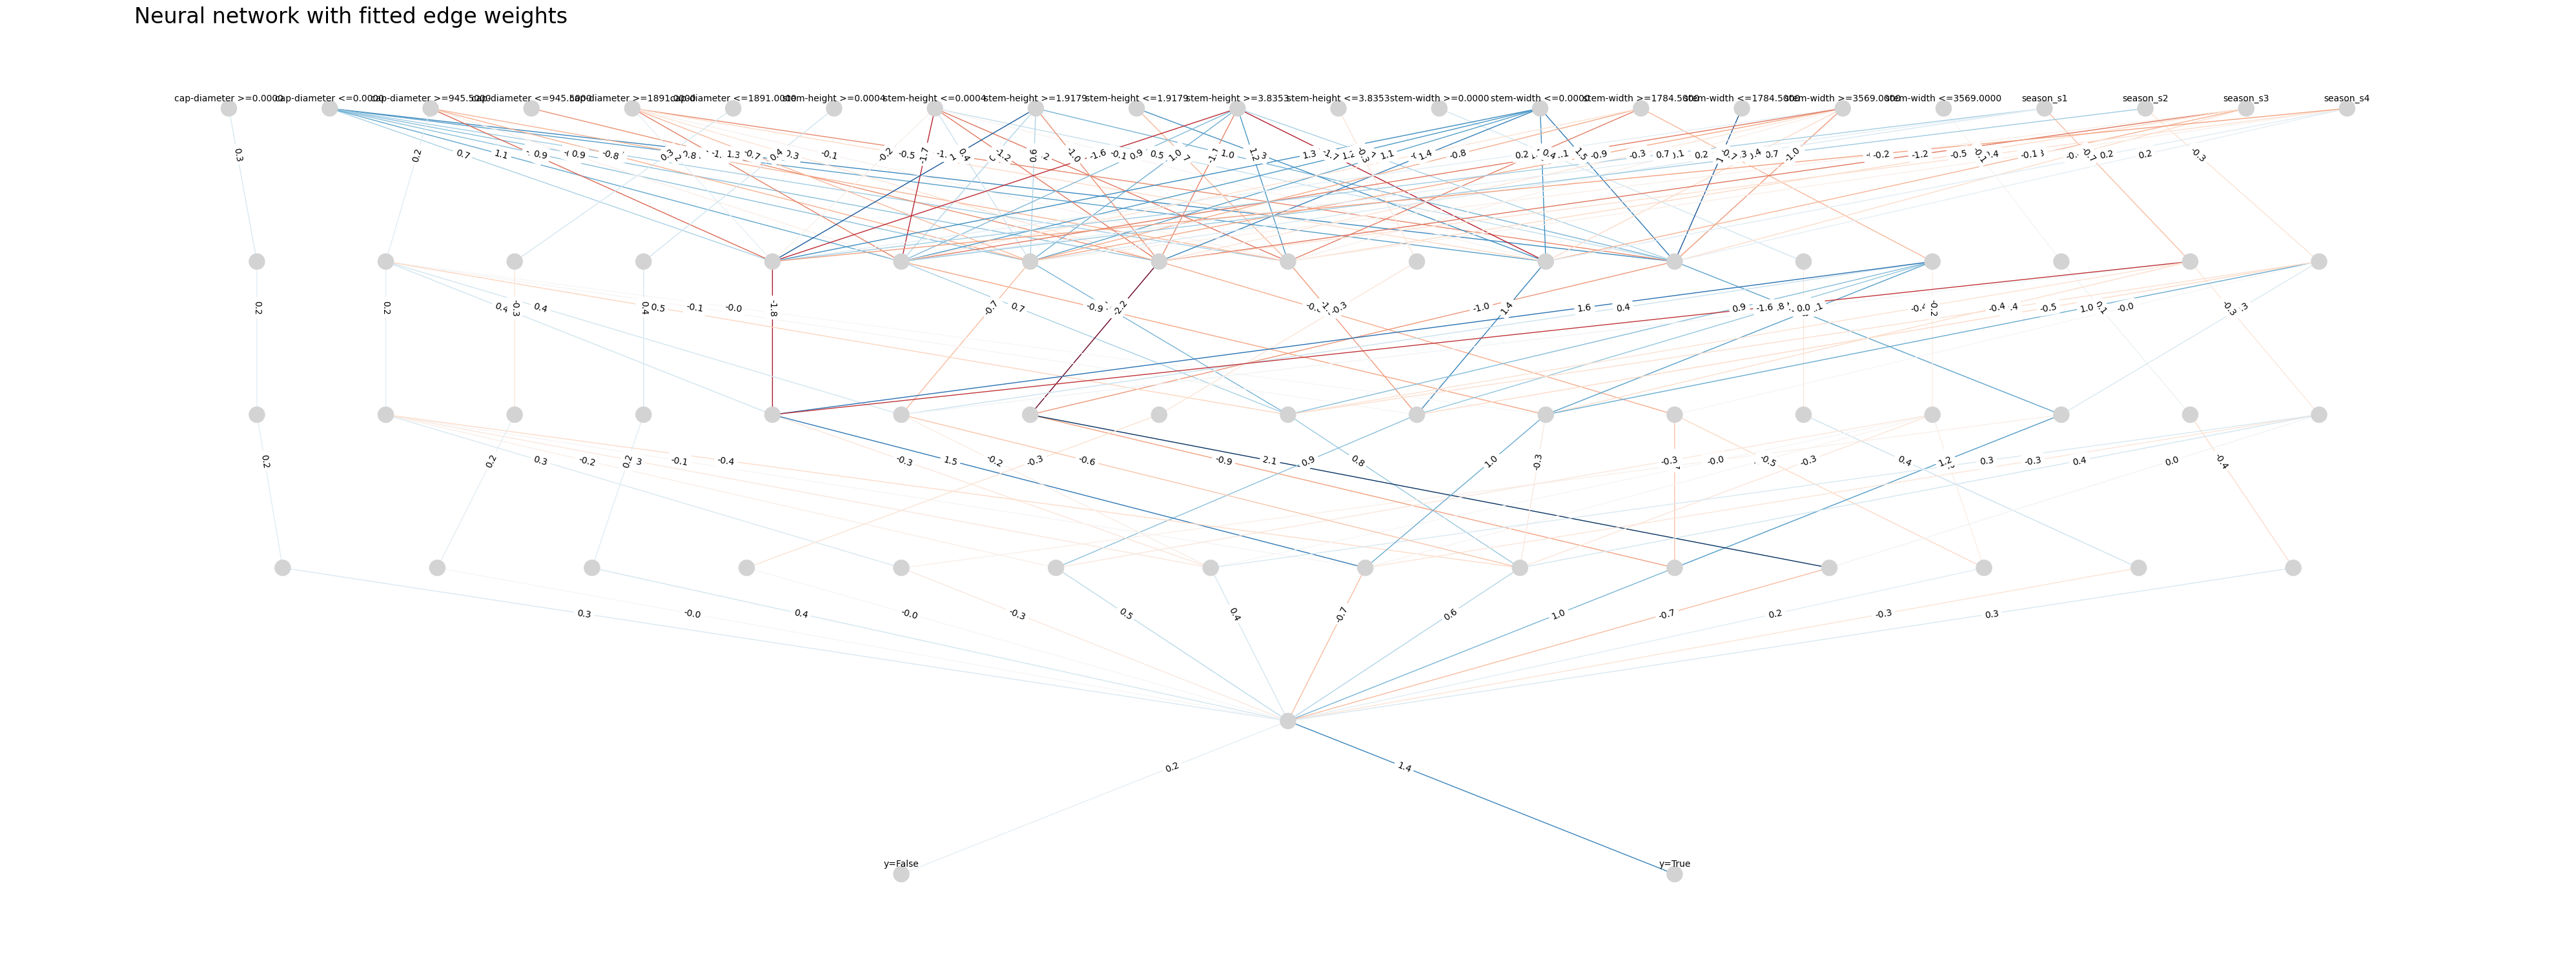

In [35]:
edge_weights = cn.edge_weights_from_network()

import networkx as nx

fig, ax = plt.subplots(figsize=(40, 15))

vis.draw_poset(
    cn.poset,
    ax=ax,
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(
        el_i, P, set(cn.attributes), only_new_attrs=True
    )
    + "\n\n",
    edge_color=[edge_weights[edge] for edge in cn.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(
    cn.poset.to_networkx(),
    vis.mover.pos,
    {k: f"{v:.1f}" for k, v in edge_weights.items()},
    label_pos=0.7,
)

plt.title("Neural network with fitted edge weights", size=24, x=0.05, loc="left")
plt.tight_layout()
plt.subplots_adjust()
plt.savefig(
    f"images/mushroom_reduced/NN_architecture_{concepts_count}concepts_fitted.png"
)
# plt.savefig(f"images/NN_architecture_{concepts_count}concepts_fitted.png")
plt.show()